# Turnover des collaborateurs à l'AN

## Introduction

Cet étude est basée sur les listes de collaborateurs par députés [publiées par l'Assemblée Nationale](http://www2.assemblee-nationale.fr/qui/liste-des-collaborateurs-par-depute), collectées et transformées par [Regards Citoyens](https://github.com/regardscitoyens/Collaborateurs-Parlement), puis concaténées et opérationnalisées par nos soins.

Elle cherche à quantifier la rotation de l'emploi, ou _turnover_, des collaborateurs en analysant la durée de leurs contrats de travail, ainsi que les caractéristiques des parlementaires qui les emploient.

Nous employons des méthodes issues de la statistique descriptive et inférentielle pour comprendre s'il existe des profils de collaborations entre les parlementaires et les assistants qu'ils emploient.

## Préparation des données

In [119]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, linregress

# Fichier généré quotidiennenement par nosdeputes.fr depuis le site de l'AN
csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

# Parsing des dates de contrat, de mandat et de naissance
csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])
csv["date_naissance"] = pd.to_datetime(csv["date_naissance"])

# Calcul des temps de contrat, de mandat et de l'âge
csv["contrat_fini"] = (csv["sortie"] != max(csv["sortie"]))
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
csv["parlementaire_age"] = (max(csv["sortie"]) - csv['date_naissance']).apply(lambda a: int(a.total_seconds()/60/60/24/365))

# Calcul du nombre de contrats courts par parlementaire
csv["contrat_plus_de_2_mois"] = (( (csv["nombredejours"] < 62) & (csv["contrat_fini"] == True)  ) == False) * 1 
csv["contrat_plus_de_4_mois"] = (( (csv["nombredejours"] < 124) & (csv["contrat_fini"] == True) ) == False) * 1
csv["contrat_plus_de_6_mois"] = (( (csv["nombredejours"] < 186) & (csv["contrat_fini"] == True) ) == False) * 1

#Preparation indicateur Rotation de l'emploi
#https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi
date_rotation = "2017-10-01"
csv["contrat_present_a_date_rotation"] = (csv["entree"] <= date_rotation) & (csv["sortie"] > date_rotation)
csv["contrat_entree_depuis_date_rotation"] = (csv["entree"] > date_rotation)
csv["contrat_sortie_depuis_date_rotation"] = (csv["sortie"] > date_rotation) & (csv["sortie"] < max(csv["sortie"]))


# Suppression des contrat inférieur à 7 jours (problème liés aux ministres)
csv = csv[csv["nombredejours"] > 7]

# Suppression des contrats courts de début de législature (fin de contrat de la législature précédente)
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]

# Suppression des colonnes inutiles du fichiers d'entrée
csv.drop("collaborateurs", 1, inplace=True)

### Contrôle

In [127]:
csv.head()

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_nosdeputes_api,url_institution,...,nombredejours,contrat_fini,duree_mandat,parlementaire_age,contrat_plus_de_2_mois,contrat_plus_de_4_mois,contrat_plus_de_6_mois,contrat_present_a_date_rotation,contrat_entree_depuis_date_rotation,contrat_sortie_depuis_date_rotation
sortie,,,,,,,,,,,,,,,,,,,,,
2017-09-05 01:15:23,Danielle Brulebois,Brulebois,Danielle,F,M. Eddy Lacroix,Lacroix,Eddy,H,https://www.nosdeputes.fr/danielle-brulebois/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,33.0,True,451,71,0,0,0,False,False,False
2017-12-24 02:15:23,Laurence Gayte,Gayte,Laurence,F,Mme Frédérique Doutres,Doutres,Frédérique,F,https://www.nosdeputes.fr/laurence-gayte/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,15.0,True,451,53,0,0,0,False,True,True
2018-05-04 01:15:29,Dominique David,David,Dominique,F,M. Zébulon Bruneteau-Paoletti,Bruneteau-Paoletti,Zébulon,H,https://www.nosdeputes.fr/dominique-david/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,27.0,True,451,55,0,0,0,False,True,True
2018-07-08 01:15:35,Audrey Dufeu Schubert,Dufeu Schubert,Audrey,F,Mme Marie Mavrikios,Mavrikios,Marie,F,https://www.nosdeputes.fr/audrey-dufeu-schuber...,http://www2.assemblee-nationale.fr/deputes/fic...,...,32.0,True,451,38,0,0,0,False,True,True
2018-04-03 01:15:32,Anne-Laurence Petel,Petel,Anne-Laurence,F,M. Pierre Cilluffo,Cilluffo,Pierre,H,https://www.nosdeputes.fr/anne-laurence-petel/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,141.0,True,451,48,1,1,0,False,True,True


### Nombre de collaborateurs 

In [60]:
len(csv['collaborateur'].unique())

2721

### Rotation de l'emploi au niveau global

La rotation de l'emploi, ou renouvellement du personnel, est [définie comme suit](https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi) : ((recrutements + fins de contrats) / 2) / 100.

Celle de l'ensemble des collaborateurs de l'Assemblée sur l'année est de 48%. D'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf), ce taux est sensiblement identique au taux national français.

In [61]:
((csv["contrat_entree_depuis_date_rotation"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation"]*1).sum())/2/(csv["contrat_present_a_date_rotation"]*1).sum()

1.215158924205379

## Temporalité des fins de contrats

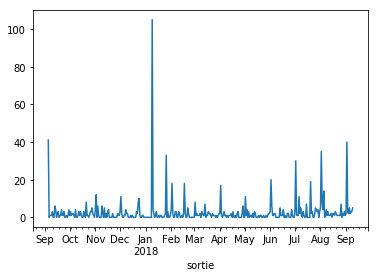

In [164]:
csv.index = csv["sortie"]
csv[csv.index != max(csv["sortie"])].resample('D').count()["nom_parlementaire"].plot()


In [171]:
csv[csv.index != max(csv["sortie"])].resample('D').count()["nom_parlementaire"].sort_values(ascending=False).head(20)

sortie
2018-01-09    105
2017-09-05     41
2018-09-02     40
2018-08-02     35
2018-01-26     33
2018-07-02     30
2018-06-02     20
2018-07-20     19
2018-02-17     18
2018-02-02     18
2018-04-02     17
2018-08-05     14
2017-11-02     12
2018-05-02     11
2018-07-06     11
2017-12-02     11
2017-12-24     10
2017-10-21      8
2018-03-02      8
2017-12-23      8
Name: nom_parlementaire, dtype: int64

## Durée des contrats

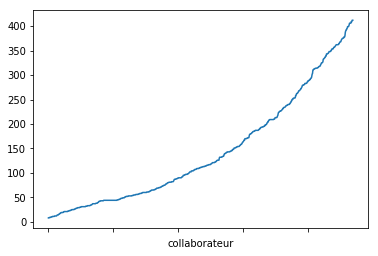

In [162]:
contrats = csv[["nombredejours", "collaborateur"]].reset_index()[["nombredejours", "collaborateur"]]
contrats.index = contrats["collaborateur"]
contrats["nombredejours"].sort_values().plot()

Le plateau de 50 jours est-il lié à l'effet janvier 2018 ou à des contrats d'opportunité/carrière

## Description générale du comportement des députés

### Préparation des données

In [151]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nom_circo']].first().rename(columns={"nom_circo": "departement"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].median().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_moyenne"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_2_mois']].sum().rename(columns={"contrat_plus_de_2_mois": "nb_contrats_plus_de_2_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_2_mois'] = duree_collaborateurs['nb_contrats_plus_de_2_mois'] / duree_collaborateurs['nb_collaborateurs']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_4_mois']].sum().rename(columns={"contrat_plus_de_4_mois": "nb_contrats_plus_de_4_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_4_mois'] = duree_collaborateurs['nb_contrats_plus_de_4_mois'] / duree_collaborateurs['nb_collaborateurs']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_6_mois']].sum().rename(columns={"contrat_plus_de_6_mois": "nb_contrats_plus_de_6_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_6_mois'] = duree_collaborateurs['nb_contrats_plus_de_6_mois'] / duree_collaborateurs['nb_collaborateurs']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].count().rename(columns={"nombredejours": "nb_contrat_fini"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs['nb_contrat_fini'].fillna(0, inplace=True)
duree_collaborateurs['ratio_contrat_fini'] = duree_collaborateurs['nb_contrat_fini'] / duree_collaborateurs['nb_collaborateurs']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['ancien_depute']].first().reset_index(), on="parlementaire")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nb_mandats']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['parlementaire_age']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.sort_values("ratio_plus_de_2_mois")#sort_values("contrat le plus long")

#Rotation emploi
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation', 'contrat_entree_depuis_date_rotation', 'contrat_sortie_depuis_date_rotation']].sum().reset_index(), on="parlementaire")
duree_collaborateurs["emploi_rotation"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation']+duree_collaborateurs['contrat_sortie_depuis_date_rotation'])/2)/duree_collaborateurs['contrat_present_a_date_rotation']
duree_collaborateurs["emploi_taux_depart"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation']/duree_collaborateurs['contrat_present_a_date_rotation']
duree_collaborateurs["emploi_taux_arrivee"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation']/duree_collaborateurs['contrat_present_a_date_rotation']

duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

### Durée des contrats de collaborateurs

Certains députés ont des collaborateurs fidèles. Le graphique suivant représente le contrat le plus long de chacun des parlementaires. Les _fidèles_ sont représentés par le palier supérieur à droite : la durée de leur contrat est égale à la durée de la législature.

On observe un second palier plus réduit à 300 jours, il représente probablement les fidèles des parlementaires suppléants de ministre du gouvernement Philippe 1.

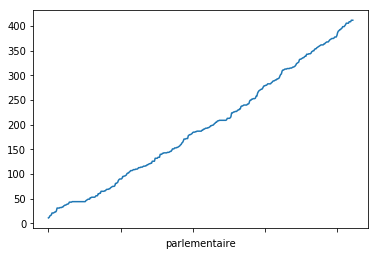

In [173]:
duree_collaborateurs.sort_values("contrat_max").set_index("parlementaire")["contrat_max"].plot()

Le graphique infra représente le contrat le plus court pour chacun des parlementaires.

Certains parlementaires n'ont aucun contrat court, ils n'ont que des collaborateurs fidèles en contrat de longue durée. D'autres se sont parfois séparé d'un collaborateur après moins de 20 jours.

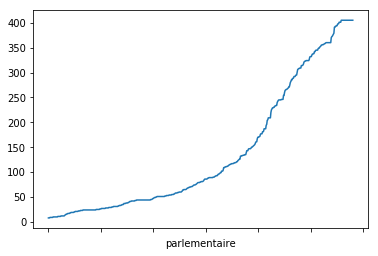

In [64]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

Près de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois : la période d'essai d'un CDI de collaborateur est de 2 mois.

In [65]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 122]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

62.1342512908778

### Rotation de l'emploi

La rotation de l'emploi moyenne des collaborateurs d'un député est de 57%. Au niveau national, elle est de 58,8% dans les établissements de 1 à 9 salariés d'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf).

La répartition par quartile et la visualisation de la distribution montrent en revanche que 25% des députés ont une rotation d'emploi nettemment au dessus de la moyenne nationale.

In [66]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation"] < 100]["emploi_rotation"].describe()

count    567.000000
mean       1.379105
std        1.019037
min        0.500000
25%        0.750000
50%        1.000000
75%        1.500000
max        7.500000
Name: emploi_rotation, dtype: float64

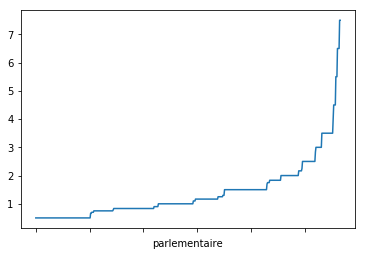

In [67]:
duree_collaborateurs.sort_values("emploi_rotation").set_index("parlementaire")["emploi_rotation"].plot()
#duree_collaborateurs["emploi_rotation"].plot()

## Les députés et leurs collaborateurs

### La durée du contrat le plus long

Le tri infra des parlementaires par la durée du contrat de collaborateur le plus long fait remonter ceux qui gardent peu de collaborateurs sur le long terme : leurs collaborateurs n'ont pas beaucoup d'ancienneté, **ils n'ont pas de fidèles**

In [68]:
# Suppression des députés nouvellement élus avant le tri
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('contrat_max').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "ratio_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,nb_contrat_fini,ratio_contrat_fini,contrat_present_a_date_rotation,contrat_entree_depuis_date_rotation,contrat_sortie_depuis_date_rotation,emploi_rotation,emploi_taux_depart,emploi_taux_arrivee
0,Amélia Lakrafi,LREM,F,Français établis hors de France,43.0,39.800000,5,43.0,5,1.0,0.0,5.0,5.0,inf,inf,inf
9,Antoine Savignat,LR,H,Val-d'Oise,110.0,110.000000,2,170.0,2,1.0,0.0,2.0,2.0,inf,inf,inf
57,José Evrard,NI,H,Pas-de-Calais,123.5,114.000000,8,180.0,8,1.0,1.0,7.0,8.0,7.500000,8.000000,7.000000
74,Anissa Khedher,LREM,F,Rhône,151.0,128.666667,6,185.0,6,1.0,3.0,3.0,6.0,1.500000,2.000000,1.000000
195,Loïc Dombreval,LREM,H,Alpes-Maritimes,189.0,162.600000,5,205.0,5,1.0,2.0,3.0,5.0,2.000000,2.500000,1.500000
521,Marie Lebec,LREM,F,Yvelines,251.5,233.750000,4,261.0,4,1.0,1.0,3.0,4.0,3.500000,4.000000,3.000000
131,Valérie Petit,LREM,F,Nord,117.0,140.625000,8,268.0,8,1.0,3.0,4.0,7.0,1.833333,2.333333,1.333333
366,Sandra Marsaud,LREM,F,Charente,99.0,145.500000,6,275.0,6,1.0,2.0,4.0,6.0,2.500000,3.000000,2.000000
42,Florence Lasserre-David,MODEM,F,Pyrénées-Atlantiques,121.0,138.000000,5,289.0,5,1.0,1.0,3.0,4.0,3.500000,4.000000,3.000000
295,Thierry Michels,LREM,H,Bas-Rhin,152.0,176.000000,7,295.0,7,1.0,3.0,4.0,7.0,1.833333,2.333333,1.333333


### Le nombre de contrats de plus de 6 mois

Le tri croissant par le ratio de contrats de plus de 6 mois sur le nombre total de contrats fait remonter les députés ayant des fidèles mais cumulant de nombreux contrats de mois de 6 mois.

In [69]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_plus_de_6_mois').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,ratio_contrat_fini,contrat_present_a_date_rotation,contrat_entree_depuis_date_rotation,contrat_sortie_depuis_date_rotation,emploi_rotation,emploi_taux_depart,emploi_taux_arrivee
0,Amélia Lakrafi,LREM,F,Français établis hors de France,43.0,39.800000,5,43.0,0.000000,5,1.0,0.0,5.0,5.0,inf,inf,inf
57,José Evrard,NI,H,Pas-de-Calais,123.5,114.000000,8,180.0,0.000000,8,1.0,1.0,7.0,8.0,7.500000,8.000000,7.000000
74,Anissa Khedher,LREM,F,Rhône,151.0,128.666667,6,185.0,0.000000,6,1.0,3.0,3.0,6.0,1.500000,2.000000,1.000000
9,Antoine Savignat,LR,H,Val-d'Oise,110.0,110.000000,2,170.0,0.000000,2,1.0,0.0,2.0,2.0,inf,inf,inf
20,Danielle Brulebois,LREM,F,Jura,83.5,107.300000,10,358.0,0.100000,10,1.0,3.0,4.0,7.0,1.833333,2.333333,1.333333
533,Guillaume Peltier,LR,H,Loir-et-Cher,158.5,178.166667,6,392.0,0.166667,6,1.0,2.0,4.0,6.0,2.500000,3.000000,2.000000
149,Sonia Krimi,LREM,F,Manche,121.0,135.111111,9,315.0,0.222222,9,1.0,1.0,7.0,8.0,7.500000,8.000000,7.000000
69,Cédric Roussel,LREM,H,Alpes-Maritimes,113.0,146.444444,9,376.0,0.222222,9,1.0,3.0,5.0,8.0,2.166667,2.666667,1.666667
251,François-Michel Lambert,LREM,H,Bouches-du-Rhône,130.0,175.750000,8,405.0,0.250000,8,1.0,3.0,5.0,8.0,2.166667,2.666667,1.666667
56,Pascale Boyer,LREM,F,Hautes-Alpes,79.5,144.000000,8,393.0,0.250000,8,1.0,2.0,6.0,8.0,3.500000,4.000000,3.000000


### Le nombre de contrats terminés

Trier les parlementaires par la proportion de contrats clos parmis tous leurs contrats de collaborateur (contrats très courts et parlementaires nouvellement élus exclus) ou par le taux de départ permet d'isoler ceux s'étant souvent séparé de leur personnel.

In [70]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_contrat_fini', ascending=False).drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "contrat_mediane", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "ratio_contrat_fini", "contrat_moyenne", "nb_collaborateurs", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini", "emploi_rotation"]].head(15)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,ratio_contrat_fini,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,emploi_rotation
0,Amélia Lakrafi,LREM,F,Français établis hors de France,1.0,39.800000,5,43.0,0.000000,5,inf
302,Sébastien Cazenove,LREM,H,Pyrénées-Orientales,1.0,271.250000,4,405.0,0.500000,4,0.833333
234,Éric Poulliat,LREM,H,Gironde,1.0,222.571429,7,400.0,0.428571,7,1.833333
235,Mireille Clapot,LREM,F,Drôme,1.0,214.857143,7,405.0,0.571429,7,1.833333
238,Nicolas Turquois,MODEM,H,Vienne,1.0,226.142857,7,405.0,0.571429,7,1.833333
239,Cécile Muschotti,LREM,F,Var,1.0,151.285714,7,405.0,0.285714,7,6.500000
240,Xavier Paluszkiewicz,LREM,H,Meurthe-et-Moselle,1.0,176.000000,7,405.0,0.285714,7,1.250000
241,Sabine Thillaye,LREM,F,Indre-et-Loire,1.0,222.428571,7,391.0,0.571429,7,0.900000
242,Célia de Lavergne,LREM,F,Drôme,1.0,163.857143,7,405.0,0.285714,7,1.250000
246,Éric Ciotti,LR,H,Alpes-Maritimes,1.0,261.125000,8,405.0,0.625000,8,1.500000


In [74]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation"] < 100].sort_values(['emploi_taux_depart', "emploi_rotation"], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_rotation", "emploi_taux_depart", "emploi_taux_arrivee", 'contrat_present_a_date_rotation', 'contrat_entree_depuis_date_rotation', 'contrat_sortie_depuis_date_rotation', "ratio_contrat_fini", "contrat_moyenne", "nb_collaborateurs", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini"]].head(50)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_rotation,emploi_taux_depart,emploi_taux_arrivee,contrat_present_a_date_rotation,contrat_entree_depuis_date_rotation,contrat_sortie_depuis_date_rotation,ratio_contrat_fini,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini
57,José Evrard,NI,H,Pas-de-Calais,7.500000,8.000000,7.000000,1.0,7.0,8.0,1.0,114.000000,8,180.0,0.000000,8
149,Sonia Krimi,LREM,F,Manche,7.500000,8.000000,7.000000,1.0,7.0,8.0,1.0,135.111111,9,315.0,0.222222,9
15,Thomas Gassilloud,LREM,H,Rhône,6.500000,7.000000,6.000000,1.0,6.0,7.0,1.0,185.375000,8,343.0,0.500000,8
27,Lénaïck Adam,LREM,H,Guyane,6.500000,7.000000,6.000000,1.0,6.0,7.0,1.0,117.285714,7,312.0,0.285714,7
127,Fabienne Colboc,LREM,F,Indre-et-Loire,6.500000,7.000000,6.000000,1.0,6.0,7.0,1.0,173.625000,8,324.0,0.375000,8
239,Cécile Muschotti,LREM,F,Var,6.500000,7.000000,6.000000,1.0,6.0,7.0,1.0,151.285714,7,405.0,0.285714,7
12,Buon Tan,LREM,H,Paris,5.500000,6.000000,5.000000,1.0,5.0,6.0,1.0,182.833333,6,405.0,0.500000,6
72,Jean-Félix Acquaviva,NI,H,Haute-Corse,5.500000,6.000000,5.000000,1.0,5.0,6.0,1.0,199.000000,6,357.0,0.500000,6
107,Patrick Vignal,LREM,H,Hérault,5.500000,6.000000,5.000000,1.0,5.0,6.0,1.0,183.125000,8,405.0,0.500000,8
82,Bertrand Sorre,LREM,H,Manche,4.500000,5.000000,4.000000,1.0,4.0,5.0,1.0,212.833333,6,405.0,0.500000,6


In [76]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation"] < 100].sort_values(["emploi_rotation",'emploi_taux_depart'], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_rotation", "emploi_taux_depart", "emploi_taux_arrivee", 'contrat_present_a_date_rotation', 'contrat_entree_depuis_date_rotation', 'contrat_sortie_depuis_date_rotation', "ratio_contrat_fini", "contrat_moyenne", "nb_collaborateurs", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini"]].head(60)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_rotation,emploi_taux_depart,emploi_taux_arrivee,contrat_present_a_date_rotation,contrat_entree_depuis_date_rotation,contrat_sortie_depuis_date_rotation,ratio_contrat_fini,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini
57,José Evrard,NI,H,Pas-de-Calais,7.500000,8.000000,7.000000,1.0,7.0,8.0,1.0,114.000000,8,180.0,0.000000,8
149,Sonia Krimi,LREM,F,Manche,7.500000,8.000000,7.000000,1.0,7.0,8.0,1.0,135.111111,9,315.0,0.222222,9
15,Thomas Gassilloud,LREM,H,Rhône,6.500000,7.000000,6.000000,1.0,6.0,7.0,1.0,185.375000,8,343.0,0.500000,8
27,Lénaïck Adam,LREM,H,Guyane,6.500000,7.000000,6.000000,1.0,6.0,7.0,1.0,117.285714,7,312.0,0.285714,7
127,Fabienne Colboc,LREM,F,Indre-et-Loire,6.500000,7.000000,6.000000,1.0,6.0,7.0,1.0,173.625000,8,324.0,0.375000,8
239,Cécile Muschotti,LREM,F,Var,6.500000,7.000000,6.000000,1.0,6.0,7.0,1.0,151.285714,7,405.0,0.285714,7
12,Buon Tan,LREM,H,Paris,5.500000,6.000000,5.000000,1.0,5.0,6.0,1.0,182.833333,6,405.0,0.500000,6
72,Jean-Félix Acquaviva,NI,H,Haute-Corse,5.500000,6.000000,5.000000,1.0,5.0,6.0,1.0,199.000000,6,357.0,0.500000,6
107,Patrick Vignal,LREM,H,Hérault,5.500000,6.000000,5.000000,1.0,5.0,6.0,1.0,183.125000,8,405.0,0.500000,8
82,Bertrand Sorre,LREM,H,Manche,4.500000,5.000000,4.000000,1.0,4.0,5.0,1.0,212.833333,6,405.0,0.500000,6


## L'influence des groupes politiques

Les durées moyennes de contrat par groupe politique pointe les non-inscrits comme le groupe parlementaire qui garde le moins longtemps ses collaborateurs.

In [72]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

,contrat_mediane
groupe_sigle,
NI,256.785714
LREM,283.143770
MODEM,288.000000
UAI,304.772727
GDR,307.470588
LR,309.872549
NG,332.419355
LFI,334.794118


# L'influence du sexe

Les durées médianes des contrats de collaborateurs femmes et hommes indiquent que les femmes restent en poste sensiblement plus longtemps, alors que collaborer avec une parlementaire femme mène à des contrats plus courts.

In [73]:
collab_femme_vs_homme = csv.groupby(["sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].median()
collab_femme_vs_homme

,nombredejours
sexe_collaborateur,
F,318.0
H,293.0


In [29]:
depute_femme_vs_homme = csv.groupby(["sexe_parlementaire"])[['nombredejours', 'sexe_collaborateur']].median()
depute_femme_vs_homme

,nombredejours
sexe_parlementaire,
F,245.0
H,281.0


On observe que seules les parlementaires femmes montrent une préférences de genre envers les hommes pour leurs collaborateurs, mais cela n'influe pas sur la durée des contrats des collaborateurs.

In [30]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['collaborateur']].count().rename(columns={'collaborateur': 'nb_collaborateurs'})
stats_sexe = duree_moy_sexe.reset_index().merge(nb_collab_sexe.reset_index(), on=["parlementaire", "sexe_collaborateur"])
stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nombredejours"]].mean()

nombredejours
sexe_parlementaire sexe_collaborateur               
F                  F                      238.298953
                   H                      224.310753
H                  F                      252.343284
                   H                      248.028012

In [31]:
nb = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].sum()
moy = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].mean()["nb_collaborateurs"].rename(columns={"nb_collaborateurs": "nb_collaborateurs_moyen"})

moy.reset_index().merge(nb.reset_index(), on=["sexe_parlementaire", "sexe_collaborateur"]).set_index(["sexe_parlementaire", "sexe_collaborateur"])


0  nb_collaborateurs
sexe_parlementaire sexe_collaborateur                             
F                  F                   2.425926                524
                   H                   2.603687                565
H                  F                   2.438806                817
                   H                   2.403614                798

## Tests statistiques sur les parlementaires

### Préparation des données

In [32]:
# Dichotomisation des variables
duree_tt = duree_collaborateurs
duree_tt["parlementaire_femme"] = (duree_tt["sexe_parlementaire"] == "F") * 1
duree_tt["parlementaire_homme"] = (duree_tt["sexe_parlementaire"] == "H") * 1
duree_tt["parlementaire_has_autre_mandats"] = (duree_tt["nb_mandats"] > 1) * 1
duree_tt["ancien_depute"] = (duree_tt["ancien_depute"]) * 1
for grp in duree_tt["groupe_sigle"].unique():
    duree_tt["groupe_"+grp] = (duree_tt["groupe_sigle"] == grp) * 1

# Inputation des valeurs manquantes
duree_tt["contrat_fini_min"].fillna(150, inplace=True)
duree_tt["contrat_fini_max"].fillna(150, inplace=True)

### Test de significativité des variables dichotomiques

Pour chacune des variables booléennes décrivant les parlementaires (sexe, groupes, etc.) on effectue un test indiquant son effet sur la durée moyenne des contrats de ses collaborateurs.

In [56]:
for i in duree_tt.drop(["nb_contrat_fini", "ratio_contrat_fini","contrat_mediane", "contrat_moyenne", "nb_collaborateurs", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois"], 1).columns[4:]:
    cat2 = duree_tt[duree_tt[i] == 0]["contrat_moyenne"]
    cat1 = duree_tt[duree_tt[i] == 1]["contrat_moyenne"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 3.327283, 0.000933

contrat_present_a_date_rotation non significatif

contrat_entree_depuis_date_rotation : -12.276270, 0.000000

contrat_sortie_depuis_date_rotation : -1.644035, 0.198716

emploi_rotation non significatif

emploi_taux_depart : -1.648596, 0.101702

emploi_taux_arrivee : -19.209933, 0.000000

parlementaire_femme : -3.781517, 0.000172

parlementaire_homme : 3.781517, 0.000172

parlementaire_has_autre_mandats non significatif

groupe_NI : -2.320214, 0.020676

groupe_GDR non significatif

groupe_MODEM non significatif

groupe_LREM : -1.808215, 0.071092

groupe_LR non significatif

groupe_UAI non significatif

groupe_NG : 1.807287, 0.071236

groupe_LFI non significatif



/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Tests de régression sur les variables continues

Pour chacune des variables continues, telles que l'âge ou le nombre de collaborateurs, décrivant les parlementaires, on effectue un test de régression qui nous indique son effet sur la durée moyenne de ses contrats.

nb_collaborateurs : slope:-0.015882, intercept:8.505215, 
	rvalue:-0.610859, pvalue:0.000000, stderr:0.000000



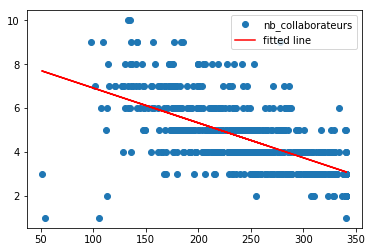

contrat_max : slope:0.248550, intercept:268.298285, 
	rvalue:0.446053, pvalue:0.000000, stderr:0.000000



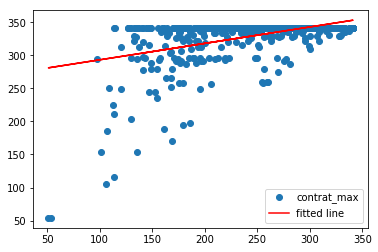

contrat_min : slope:1.454013, intercept:-221.268060, 
	rvalue:0.829474, pvalue:0.000000, stderr:0.000000



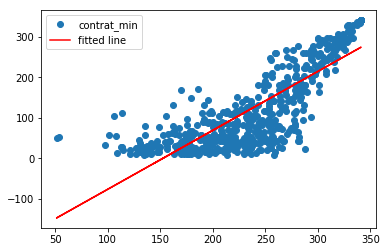

nb_contrats_plus_de_2_mois : slope:-0.009054, intercept:6.438250, 
	rvalue:-0.417698, pvalue:0.000000, stderr:0.000000



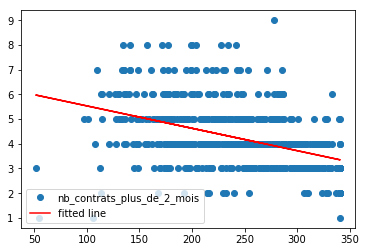

nb_contrats_plus_de_4_mois : slope:-0.004414, intercept:5.010103, 
	rvalue:-0.226391, pvalue:0.000000, stderr:0.000000



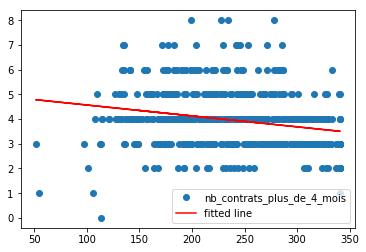

nb_contrats_plus_de_6_mois : slope:-0.002087, intercept:4.278915, 
	rvalue:-0.112807, pvalue:0.006490, stderr:0.006490



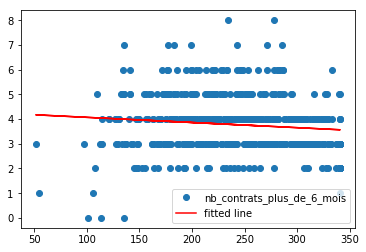

nb_contrat_fini : slope:-0.015332, intercept:4.869225, 
	rvalue:-0.747881, pvalue:0.000000, stderr:0.000000



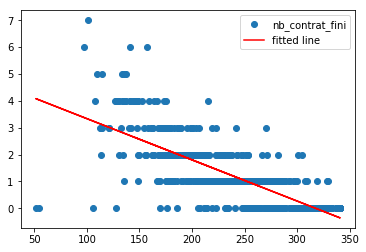

contrat_fini_max : non significatif

contrat_fini_min : slope:0.565362, intercept:-17.537606, 
	rvalue:0.509623, pvalue:0.000000, stderr:0.000000



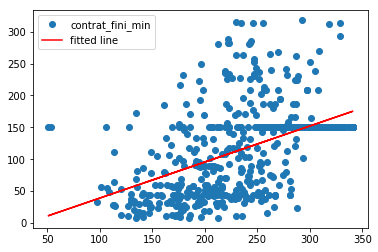

ancien_depute : slope:0.001007, intercept:0.036291, 
	rvalue:0.136022, pvalue:0.001013, stderr:0.001013



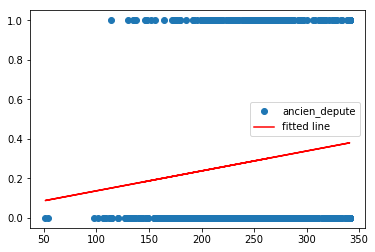

ratio_contrat_mandat : slope:0.002863, intercept:0.022703, 
	rvalue:0.559534, pvalue:0.000000, stderr:0.000000



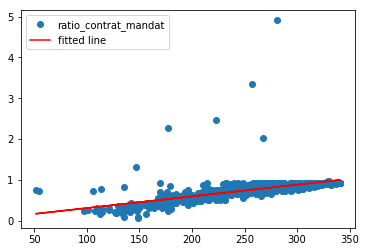

nb_mandats : non significatif

parlementaire_age : slope:0.024247, intercept:43.815824, 
	rvalue:0.132611, pvalue:0.001357, stderr:0.001357



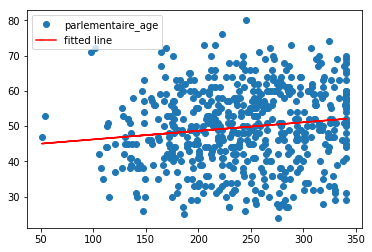

contrat_present_a_date_rotation : slope:0.004457, intercept:1.740238, 
	rvalue:0.247155, pvalue:0.000000, stderr:0.000000



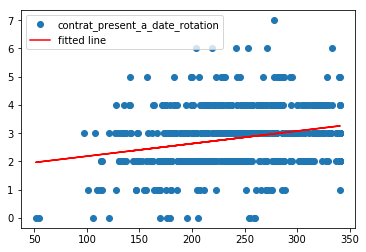

contrat_entree_depuis_date_rotation : slope:-0.018480, intercept:6.176385, 
	rvalue:-0.781032, pvalue:0.000000, stderr:0.000000



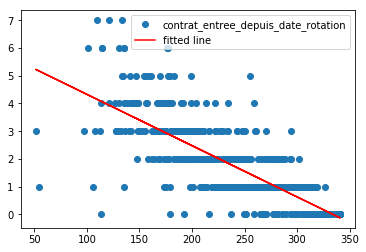

contrat_sortie_depuis_date_rotation : slope:-0.013472, intercept:4.280633, 
	rvalue:-0.700970, pvalue:0.000000, stderr:0.000000



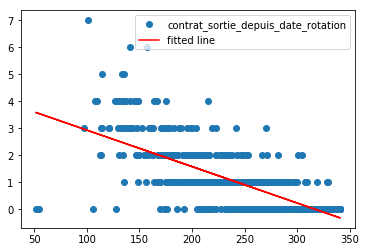

emploi_rotation : non significatif

emploi_taux_depart : non significatif

emploi_taux_arrivee : non significatif

parlementaire_femme : slope:-0.001279, intercept:0.702568, 
	rvalue:-0.158907, pvalue:0.000120, stderr:0.000120



/Users/diego.antolinosbasso/.virtualenvs/lfdll/lib/python3.6/site-packages/numpy/lib/function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


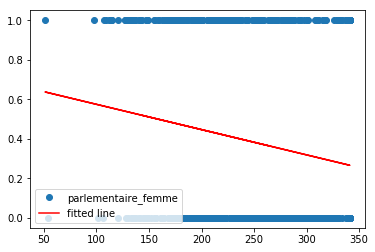

parlementaire_homme : slope:0.001279, intercept:0.297432, 
	rvalue:0.158907, pvalue:0.000120, stderr:0.000120



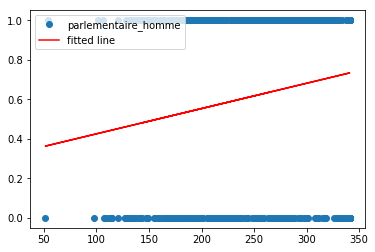

parlementaire_has_autre_mandats : non significatif

groupe_LREM : slope:-0.000648, intercept:0.697505, 
	rvalue:-0.078846, pvalue:0.057517, stderr:0.057517



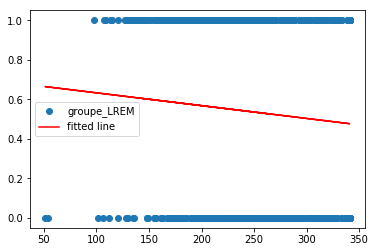

groupe_LR : non significatif

groupe_NI : slope:-0.000291, intercept:0.104975, 
	rvalue:-0.096816, pvalue:0.019590, stderr:0.019590



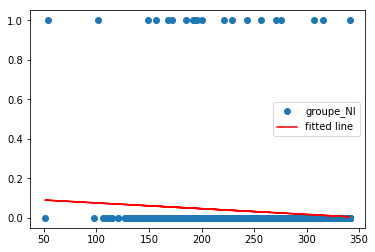

groupe_LFI : non significatif

groupe_MODEM : non significatif

groupe_GDR : non significatif

groupe_UAI : non significatif

groupe_NG : slope:0.000265, intercept:-0.010849, 
	rvalue:0.071474, pvalue:0.085195, stderr:0.085195



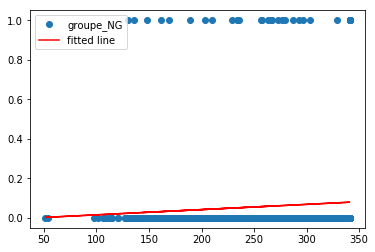

In [34]:
tt = {}
for i in duree_tt.columns[4:].drop(["contrat_moyenne", "contrat_mediane", "duree_mandat", "ratio_plus_de_2_mois", "ratio_plus_de_4_mois", "ratio_plus_de_6_mois", "ratio_contrat_fini"], 1):
    tt[i] = linregress(duree_tt["contrat_moyenne"], duree_tt[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(duree_tt["contrat_moyenne"], duree_tt[i], 'o', label=i)
        plt.plot(duree_tt["contrat_moyenne"], tt[i].intercept + tt[i].slope*duree_tt["contrat_moyenne"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Tests statistiques sur les collaborateurs

### Préparation des données

In [35]:
tous_collaborateurs = csv.merge(duree_collaborateurs.drop([ 'groupe_sigle', 'sexe_parlementaire', 'duree_mandat', 'nb_mandats', 'parlementaire_age', 'ancien_depute'], 1), on="parlementaire")
tous_collaborateurs["collaborateur_femme"] = (tous_collaborateurs["sexe_collaborateur"] == "F") * 1
tous_collaborateurs["collaborateur_homme"] = (tous_collaborateurs["sexe_collaborateur"] == "H") * 1
tous_collaborateurs.to_csv("../data/turnover_collaborateurs_variables.csv")
tous_collaborateurs = tous_collaborateurs.drop(["entree", "sortie"], 1)

tous_collaborateurs = tous_collaborateurs.drop(['groupe_sigle', 'parti_ratt_financier', 'sites_web','emails', 'adresses', 'autres_mandats', 'anciens_autres_mandats', 'anciens_mandats', 'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug', 'url_nosdeputes', "duree_mandat", "departement"], 1)
#tous_collaborateurs.columns[24:]

### Test de significativité des variables dichotomiques

In [36]:
for i in tous_collaborateurs.columns[24:].drop(["contrat_fini", "contrat_plus_de_2_mois", "nombredejours","contrat_plus_de_4_mois", "contrat_plus_de_6_mois","parlementaire_age","contrat_mediane","contrat_moyenne","nb_collaborateurs","contrat_max","contrat_min","nb_contrats_plus_de_2_mois","ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois","nb_contrat_fini","ratio_contrat_fini","contrat_fini_max","contrat_fini_min","ratio_contrat_mandat"], 1):
    cat2 = tous_collaborateurs[tous_collaborateurs[i] == 0]["nombredejours"]
    cat1 = tous_collaborateurs[tous_collaborateurs[i] == 1]["nombredejours"]
    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 4.591281, 0.000005

nb_mandats non significatif

contrat_present_a_date_rotation_x : 52.418472, 0.000000

contrat_entree_depuis_date_rotation_x : -41.227145, 0.000000

contrat_sortie_depuis_date_rotation_x : -28.618529, 0.000000

contrat_present_a_date_rotation_y non significatif

contrat_entree_depuis_date_rotation_y : -9.578942, 0.000000

contrat_sortie_depuis_date_rotation_y : -10.469088, 0.000000

emploi_rotation : -18.828452, 0.000000

emploi_taux_depart : -17.929531, 0.000000

emploi_taux_arrivee : -17.362197, 0.000000

parlementaire_femme : -5.493780, 0.000000

parlementaire_homme : 5.493780, 0.000000

parlementaire_has_autre_mandats non significatif

groupe_LREM : -3.741216, 0.000187

groupe_LR : 2.417939, 0.015674

groupe_NI : -2.072519, 0.038312

groupe_LFI : 1.672076, 0.094625

groupe_MODEM non significatif

groupe_GDR non significatif

groupe_UAI non significatif

groupe_NG : 2.302160, 0.021402

collaborateur_femme : 2.188292, 0.028734

collaborateur_homme :

### Tests de régression sur les variables continues

ancien_depute : slope:0.000355, intercept:0.204707, 
	rvalue:0.087984, pvalue:0.000005, stderr:0.000005



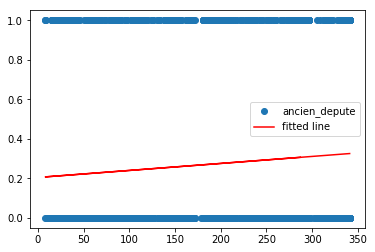

nb_mandats : non significatif

contrat_fini : slope:-0.002202, intercept:0.753775, 
	rvalue:-0.572368, pvalue:0.000000, stderr:0.000000



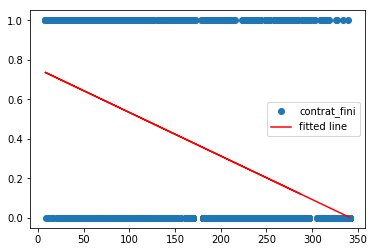

parlementaire_age : slope:0.007581, intercept:47.694452, 
	rvalue:0.077194, pvalue:0.000059, stderr:0.000059



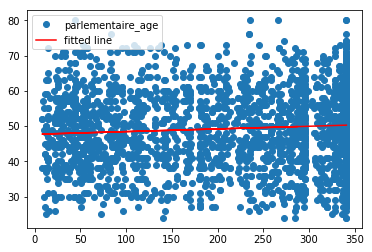

contrat_plus_de_2_mois : slope:0.001333, intercept:0.605012, 
	rvalue:0.526834, pvalue:0.000000, stderr:0.000000



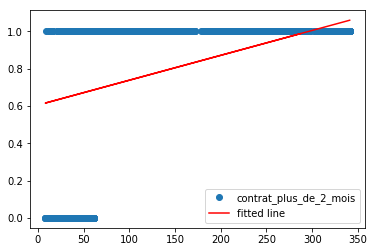

contrat_plus_de_4_mois : slope:0.002045, intercept:0.376425, 
	rvalue:0.636136, pvalue:0.000000, stderr:0.000000



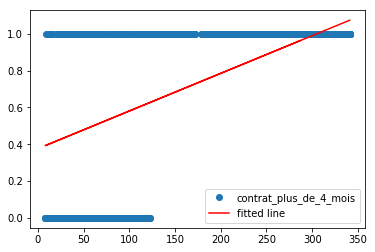

contrat_plus_de_6_mois : slope:0.002267, intercept:0.289449, 
	rvalue:0.648872, pvalue:0.000000, stderr:0.000000



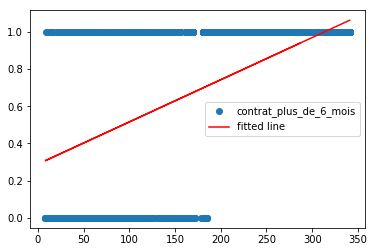

contrat_present_a_date_rotation_x : slope:0.003094, intercept:-0.105164, 
	rvalue:0.710065, pvalue:0.000000, stderr:0.000000



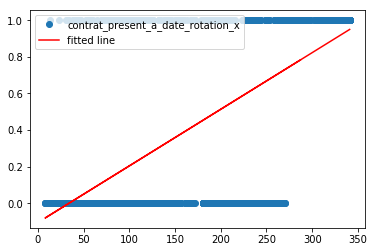

contrat_entree_depuis_date_rotation_x : slope:-0.002666, intercept:0.977362, 
	rvalue:-0.621404, pvalue:0.000000, stderr:0.000000



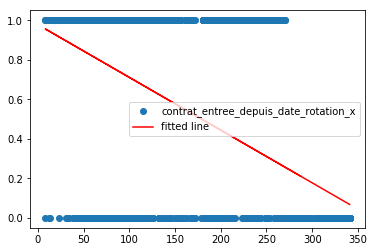

contrat_sortie_depuis_date_rotation_x : slope:-0.001775, intercept:0.625974, 
	rvalue:-0.482295, pvalue:0.000000, stderr:0.000000



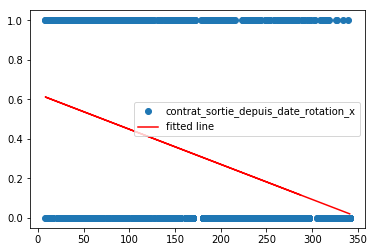

nb_collaborateurs : slope:-0.005069, intercept:6.354051, 
	rvalue:-0.339700, pvalue:0.000000, stderr:0.000000



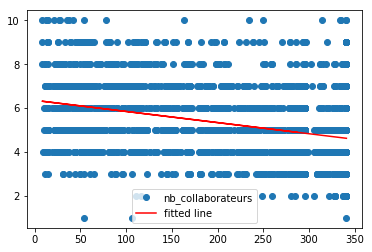

contrat_max : slope:0.060538, intercept:314.857053, 
	rvalue:0.223506, pvalue:0.000000, stderr:0.000000



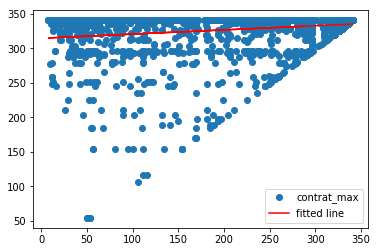

contrat_min : slope:0.373974, intercept:22.943610, 
	rvalue:0.431207, pvalue:0.000000, stderr:0.000000



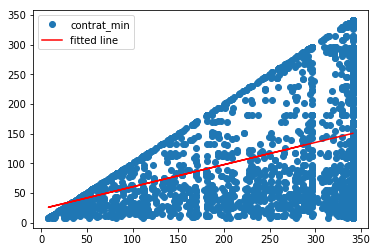

nb_contrats_plus_de_2_mois : slope:-0.002669, intercept:5.252705, 
	rvalue:-0.217014, pvalue:0.000000, stderr:0.000000



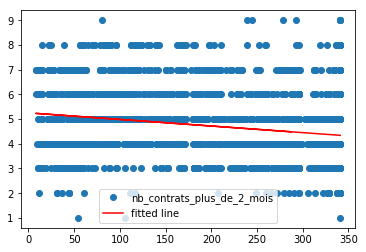

nb_contrats_plus_de_4_mois : slope:-0.001118, intercept:4.508496, 
	rvalue:-0.101423, pvalue:0.000000, stderr:0.000000



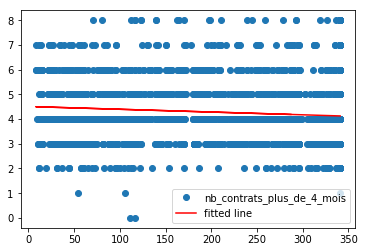

nb_contrats_plus_de_6_mois : slope:-0.000366, intercept:4.119258, 
	rvalue:-0.034947, pvalue:0.069222, stderr:0.069222



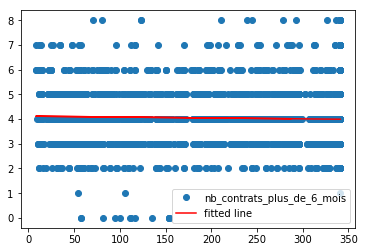

nb_contrat_fini : slope:-0.005115, intercept:2.643496, 
	rvalue:-0.415600, pvalue:0.000000, stderr:0.000000



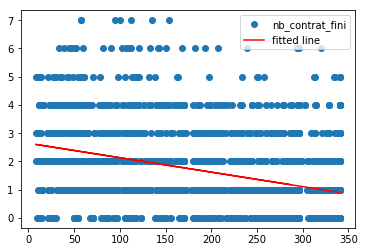

ratio_contrat_fini : slope:-0.000717, intercept:0.412257, 
	rvalue:-0.401767, pvalue:0.000000, stderr:0.000000



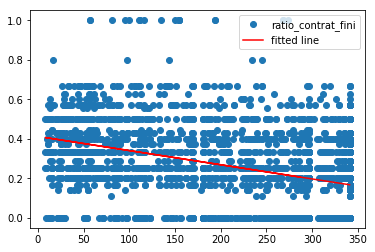

contrat_fini_max : non significatif

contrat_fini_min : slope:0.183314, intercept:67.723535, 
	rvalue:0.293288, pvalue:0.000000, stderr:0.000000



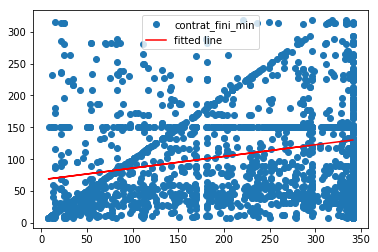

ratio_contrat_mandat : slope:0.000919, intercept:0.463178, 
	rvalue:0.320247, pvalue:0.000000, stderr:0.000000



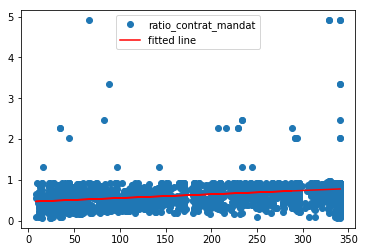

contrat_present_a_date_rotation_y : slope:0.001427, intercept:2.639817, 
	rvalue:0.138536, pvalue:0.000000, stderr:0.000000



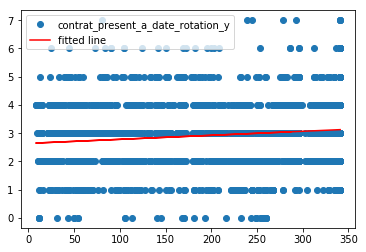

contrat_entree_depuis_date_rotation_y : slope:-0.005875, intercept:3.395662, 
	rvalue:-0.425328, pvalue:0.000000, stderr:0.000000



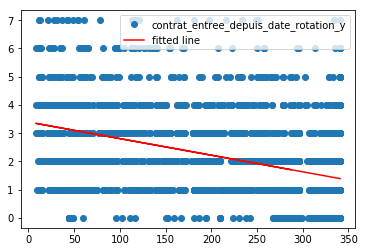

contrat_sortie_depuis_date_rotation_y : slope:-0.004495, intercept:2.324925, 
	rvalue:-0.389106, pvalue:0.000000, stderr:0.000000



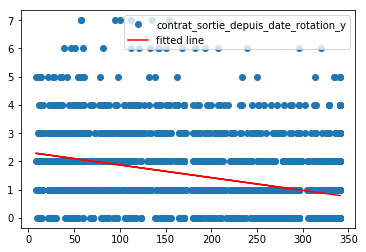

emploi_rotation : non significatif

emploi_taux_depart : non significatif

emploi_taux_arrivee : non significatif

parlementaire_femme : slope:-0.000460, intercept:0.508421, 
	rvalue:-0.105103, pvalue:0.000000, stderr:0.000000



/Users/diego.antolinosbasso/.virtualenvs/lfdll/lib/python3.6/site-packages/numpy/lib/function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


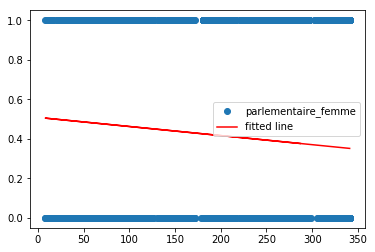

parlementaire_homme : slope:0.000460, intercept:0.491579, 
	rvalue:0.105103, pvalue:0.000000, stderr:0.000000



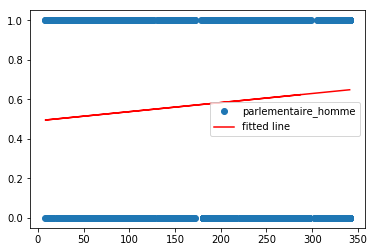

parlementaire_has_autre_mandats : non significatif

groupe_LREM : slope:-0.000319, intercept:0.619137, 
	rvalue:-0.071787, pvalue:0.000187, stderr:0.000187



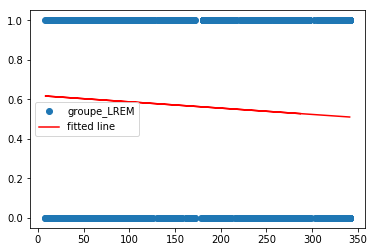

groupe_LR : slope:0.000160, intercept:0.144518, 
	rvalue:0.046466, pvalue:0.015674, stderr:0.015674



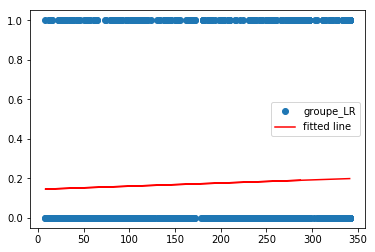

groupe_NI : slope:-0.000066, intercept:0.051063, 
	rvalue:-0.039839, pvalue:0.038312, stderr:0.038312



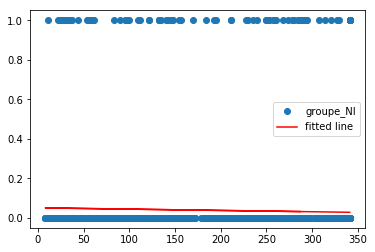

groupe_LFI : slope:0.000049, intercept:0.018417, 
	rvalue:0.032151, pvalue:0.094625, stderr:0.094625



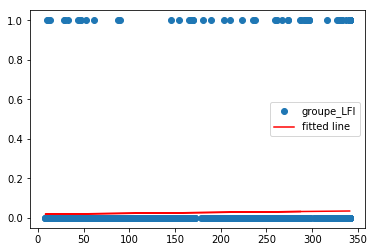

groupe_MODEM : non significatif

groupe_GDR : non significatif

groupe_UAI : non significatif

groupe_NG : slope:0.000085, intercept:0.028970, 
	rvalue:0.044245, pvalue:0.021402, stderr:0.021402



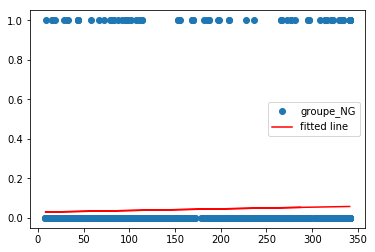

collaborateur_femme : slope:0.000188, intercept:0.452817, 
	rvalue:0.042061, pvalue:0.028734, stderr:0.028734



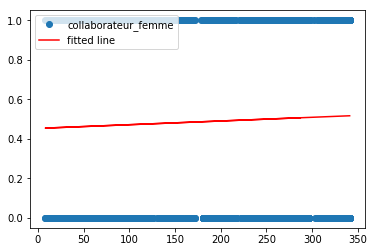

collaborateur_homme : slope:-0.000188, intercept:0.547183, 
	rvalue:-0.042061, pvalue:0.028734, stderr:0.028734



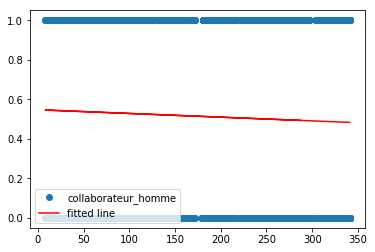

In [37]:
tt = {}
for i in tous_collaborateurs.drop(["nombredejours", "contrat_moyenne", "contrat_mediane", "ratio_plus_de_2_mois","ratio_plus_de_4_mois","ratio_plus_de_6_mois"], 1).columns[24:]:
    tt[i] = linregress(tous_collaborateurs["nombredejours"], tous_collaborateurs[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(tous_collaborateurs["nombredejours"], tous_collaborateurs[i], 'o', label=i)
        plt.plot(tous_collaborateurs["nombredejours"], tt[i].intercept + tt[i].slope*tous_collaborateurs["nombredejours"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Conclusions

On observe une rotation du travail moyenne à l'échelle de l'Assemblée comparable au taux moyen français pour les entreprises de petite taille. Malgré cela, certains parlementaires ont un taux sensiblement au-dessus de la moyenne.

Nous avons isolé des parlementaires dont le taux de rotation de l'emploi est le plus haut grâce à des critères descriptifs simples basés sur les temps de contrats des collaborateurs et leur nombre de collaborateurs.

Une série de tests statistiques nous a permis de mesurer l'effet de différentes caractéristiques des parlementaires (sexe, âge, groupe politique, etc...) sur la durée médiane des contrats de leurs collaborateurs.

Des profils de managers et d'employés émergent de notre analyse des données collectées depuis le 22 juin 2017. La présence de collaborateurs fidèles, l'influence du sexe, de l'âge ou de l'ancienneté du parlementaire sur la durée des collaborations, ou encore la propension des groupes LREM et NI a se séparer plus rapidement de leur collaborateurs méritent d'être étudiés plus en détails. Notamment à la lumière d'informations complémentaires sur la teneur des contrats des collaborateurs parlementaires.